# Learning the Embedding with the use of Neural Networks
W'll use Neural Collaborative Filtering (https://arxiv.org/pdf/1708.05031.pdf) to create a NN that learns the embedding of the data

## Necessary imports

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for machine learning
from sklearn import preprocessing, metrics

## Importing the data

In [24]:
movies = pd.read_excel('data/movie_e.xlsx')

In [25]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254       Kein Bund fÃ¼r's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
27273                                       Comedy  
27274                                       Comedy  
27275                                    Adventure  
27276                           (no genres listed)  
27277                     Adventure|Fantasy|Horror  

[27278 rows x 3 columns]

In [26]:
user_rating = pd.read_csv('data/rating.csv')

In [27]:
user_rating

userId  movieId  rating            timestamp
0              1        2     3.5  2005-04-02 23:53:47
1              1       29     3.5  2005-04-02 23:31:16
2              1       32     3.5  2005-04-02 23:33:39
3              1       47     3.5  2005-04-02 23:32:07
4              1       50     3.5  2005-04-02 23:29:40
...          ...      ...     ...                  ...
20000258  138493    68954     4.5  2009-11-13 15:42:00
20000259  138493    69526     4.5  2009-12-03 18:31:48
20000260  138493    69644     3.0  2009-12-07 18:10:57
20000261  138493    70286     5.0  2009-11-13 15:42:24
20000262  138493    71619     2.5  2009-10-17 20:25:36

[20000263 rows x 4 columns]

#### Prepare movies data:

In [28]:
movies = movies[~movies["genres"].isna()]
movies["entry_id"] = range(0, len(movies))
regexp = re.compile(r'[(]\d*?[)]') # mathces (number)

# remove the release year of movies, and save it in another column
movies["movie_name"] = movies["title"].apply(lambda x:
                                             re.sub(regexp, "", x).strip())
# print(movies.loc[15646])
# get the release year and save it in another column

movies["date"] = movies["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").replace("\"", "").strip()) if regexp.search(x) else np.nan)

movies["date"] = movies["date"].fillna(9999)
movies["old"] = movies["date"].apply(lambda x: 1 if x < 2000 else 0)

In [29]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254       Kein Bund fÃ¼r's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  entry_id  \
0      Adventure|Animation|Children|Comedy|Fantasy         0   
1                       Adventure|Children|Fantasy         1   
2                                   Comedy|Romance         2   
3                             Comedy|Drama|Romance         3   
4                                           Comedy         4   
...                                            ...       ...   
27273                                       Comedy     27273   
27274                                       Comedy     27274   
27275                                    Adventure     27275   
27276                           (no genres listed)     27276   
27277                     Adventure|Fantasy|Horror     27277   

                        movie_name    date  old  
0                        Toy Story  1995.0    1  
1                          Jumanji  1995.0    1  
2                 Grumpier Old Men  1995.0    1  
3                Waiting to Exhale  1995.0    1  
4      Father of the Bride Part II  1995.0    1  
...                            ...     ...  ...  
27273       Kein Bund fÃ¼r's Leben  2007.0    0  
27274       Feuer, Eis & Dosenbier  2002.0    0  
27275                  The Pirates  2014.0    0  
27276                 Rentun Ruusu  2001.0    0  
27277                    Innocence  2014.0    0  

[27278 rows x 7 columns]

#### Prepare user-rating data:

In [30]:
user_rating["user"] = user_rating["userId"].apply(lambda x: x-1)
# FOR CONTEXT_BASED:
# user_rating["timestamp"] = user_rating["timestamp"].apply(lambda x: datetime.fromtimestamp(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
# user_rating["daytime"] = user_rating["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# user_rating["weekend"] = user_rating["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
user_rating = user_rating.merge(movies[["movieId","entry_id"]], how="left")
user_rating = user_rating.rename(columns={"rating":"y"})

In [31]:
movies = movies[["entry_id", "movie_name", "old", "genres"]].set_index("entry_id")
user_rating = user_rating[["user", "entry_id", "timestamp", "y"]]

In [32]:
user_rating

user  entry_id            timestamp    y
0              0         1  2005-04-02 23:53:47  3.5
1              0        28  2005-04-02 23:31:16  3.5
2              0        31  2005-04-02 23:33:39  3.5
3              0        46  2005-04-02 23:32:07  3.5
4              0        49  2005-04-02 23:29:40  3.5
...          ...       ...                  ...  ...
20000258  138492     13767  2009-11-13 15:42:00  4.5
20000259  138492     13876  2009-12-03 18:31:48  4.5
20000260  138492     13890  2009-12-07 18:10:57  3.0
20000261  138492     14009  2009-11-13 15:42:24  5.0
20000262  138492     14293  2009-10-17 20:25:36  2.5

[20000263 rows x 4 columns]

In [33]:
movies

movie_name  old  \
entry_id                                     
0                           Toy Story    1   
1                             Jumanji    1   
2                    Grumpier Old Men    1   
3                   Waiting to Exhale    1   
4         Father of the Bride Part II    1   
...                               ...  ...   
27273          Kein Bund fÃ¼r's Leben    0   
27274          Feuer, Eis & Dosenbier    0   
27275                     The Pirates    0   
27276                    Rentun Ruusu    0   
27277                       Innocence    0   

                                               genres  
entry_id                                               
0         Adventure|Animation|Children|Comedy|Fantasy  
1                          Adventure|Children|Fantasy  
2                                      Comedy|Romance  
3                                Comedy|Drama|Romance  
4                                              Comedy  
...                                               ...  
27273                                          Comedy  
27274                                          Comedy  
27275                                       Adventure  
27276                              (no genres listed)  
27277                        Adventure|Fantasy|Horror  

[27278 rows x 3 columns]

#### product-feature matrix:

In [34]:
tags = [i.split("|") for i in movies["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
for col in columns:
    movies[col] = movies["genres"].apply(lambda x: 1 if col in x else 0)

In [13]:
movies

movie_name  old  \
entry_id                                     
0                           Toy Story    1   
1                             Jumanji    1   
2                    Grumpier Old Men    1   
3                   Waiting to Exhale    1   
4         Father of the Bride Part II    1   
...                               ...  ...   
27273          Kein Bund fÃ¼r's Leben    0   
27274          Feuer, Eis & Dosenbier    0   
27275                     The Pirates    0   
27276                    Rentun Ruusu    0   
27277                       Innocence    0   

                                               genres  Romance  Mystery  \
entry_id                                                                  
0         Adventure|Animation|Children|Comedy|Fantasy        0        0   
1                          Adventure|Children|Fantasy        0        0   
2                                      Comedy|Romance        1        0   
3                                Comedy|Drama|Romance        1        0   
4                                              Comedy        0        0   
...                                               ...      ...      ...   
27273                                          Comedy        0        0   
27274                                          Comedy        0        0   
27275                                       Adventure        0        0   
27276                              (no genres listed)        0        0   
27277                        Adventure|Fantasy|Horror        0        0   

          Drama  Film-Noir  Children  Sci-Fi  Crime  ...  Documentary  War  \
entry_id                                             ...                     
0             0          0         1       0      0  ...            0    0   
1             0          0         1       0      0  ...            0    0   
2             0          0         0       0      0  ...            0    0   
3             1          0         0       0      0  ...            0    0   
4             0          0         0       0      0  ...            0    0   
...         ...        ...       ...     ...    ...  ...          ...  ...   
27273         0          0         0       0      0  ...            0    0   
27274         0          0         0       0      0  ...            0    0   
27275         0          0         0       0      0  ...            0    0   
27276         0          0         0       0      0  ...            0    0   
27277         0          0         0       0      0  ...            0    0   

          Fantasy  Comedy  IMAX  Musical  Thriller  Animation  Western  \
entry_id                                                                 
0               1       1     0        0         0          1        0   
1               1       0     0        0         0          0        0   
2               0       1     0        0         0          0        0   
3               0       1     0        0         0          0        0   
4               0       1     0        0         0          0        0   
...           ...     ...   ...      ...       ...        ...      ...   
27273           0       1     0        0         0          0        0   
27274           0       1     0        0         0          0        0   
27275           0       0     0        0         0          0        0   
27276           0       0     0        0         0          0        0   
27277           1       0     0        0         0          0        0   

          Adventure  
entry_id             
0                 1  
1                 1  
2                 0  
3                 0  
4                 0  
...             ...  
27273             0  
27274             0  
27275             1  
27276             0  
27277             1  

[27278 rows x 22 columns]

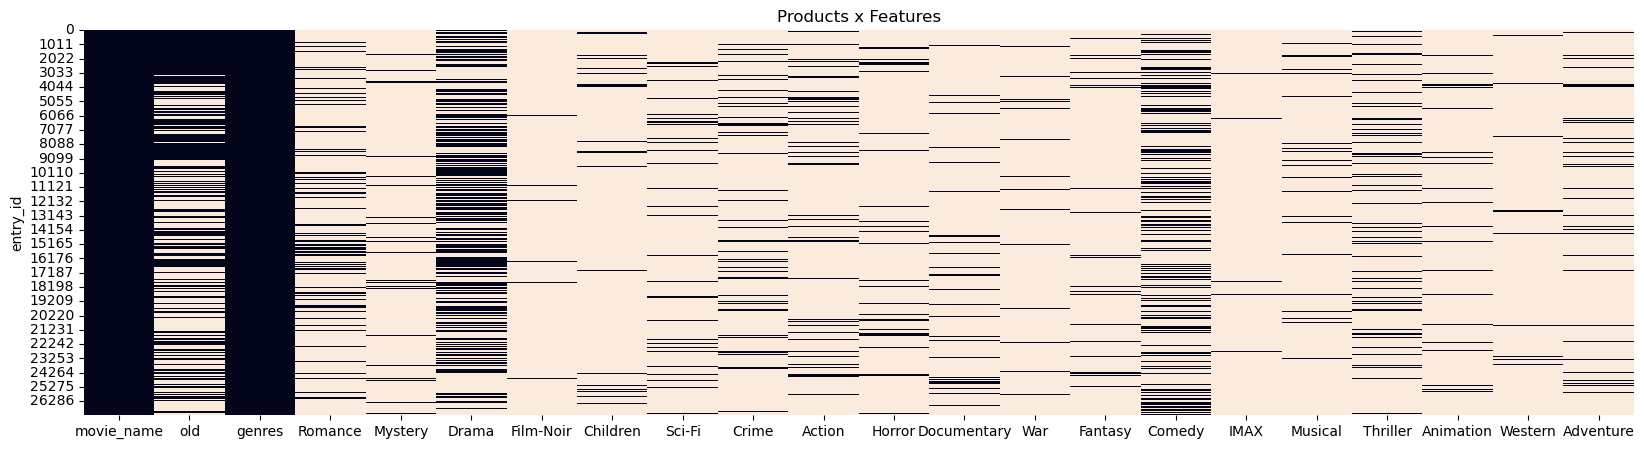

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [15]:
user_rating

user  entry_id            timestamp    y
0              0         1  2005-04-02 23:53:47  3.5
1              0        28  2005-04-02 23:31:16  3.5
2              0        31  2005-04-02 23:33:39  3.5
3              0        46  2005-04-02 23:32:07  3.5
4              0        49  2005-04-02 23:29:40  3.5
...          ...       ...                  ...  ...
20000258  138492     13767  2009-11-13 15:42:00  4.5
20000259  138492     13876  2009-12-03 18:31:48  4.5
20000260  138492     13890  2009-12-07 18:10:57  3.0
20000261  138492     14009  2009-11-13 15:42:24  5.0
20000262  138492     14293  2009-10-17 20:25:36  2.5

[20000263 rows x 4 columns]

In [ ]:
tmp = user_rating.copy()
tmp = tmp.head(10000) #< heap memory exceded otherwise
user_rating = tmp.pivot_table(index="user", columns="entry_id", values="y")
missing_cols = list(set(movies.index) - set(user_rating.columns))
for col in missing_cols:
    user_rating[col] = np.nan
user_rating = user_rating[sorted(user_rating.columns)]

C:\Users\sorana\AppData\Local\Temp\ipykernel_15688\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_rating[col] = np.nan
C:\Users\sorana\AppData\Local\Temp\ipykernel_15688\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_rating[col] = np.nan
C:\Users\sorana\AppData\Local\Temp\ipykernel_15688\84046471.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

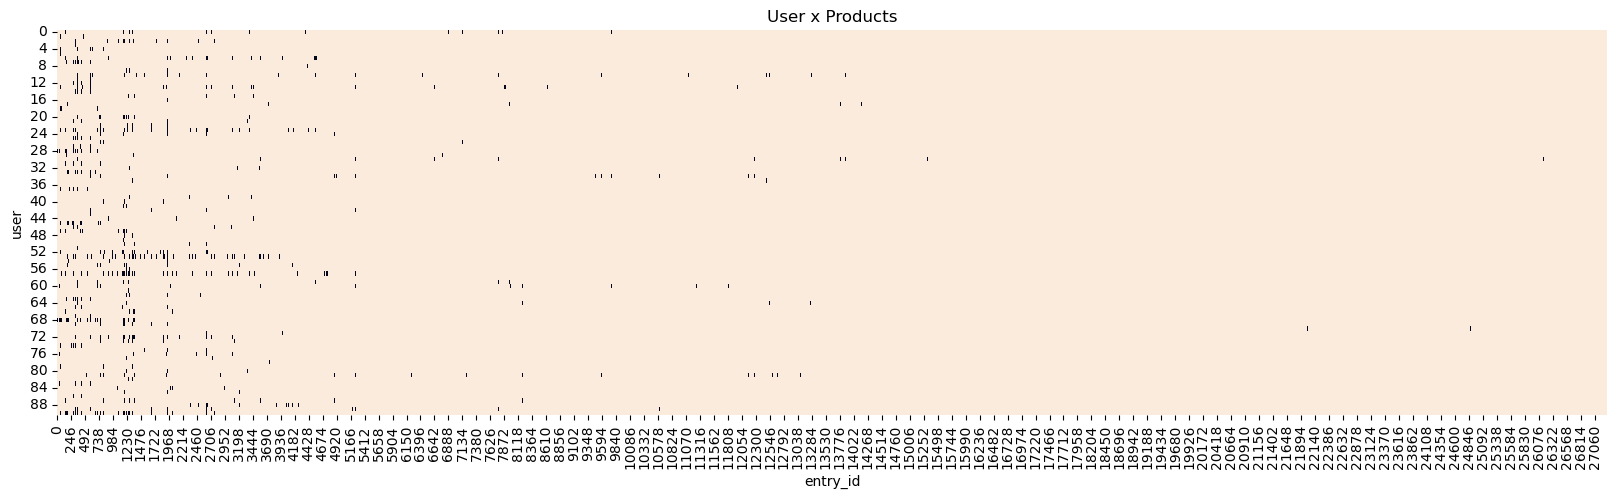

In [17]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(user_rating.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("User x Products")
plt.show()

# Preprocess data

In [18]:
user_rating = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(user_rating.values), 
                         columns=user_rating.columns, index=user_rating.index)

C:\Users\sorana\.conda\envs\recomsys\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\sorana\.conda\envs\recomsys\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [19]:
user_rating

entry_id   0      1      2      3      4         5       6      7      8      \
user                                                                           
0            NaN    1.0    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
1            NaN    NaN   0.75    NaN    NaN       NaN     NaN    NaN    NaN   
2         0.8750    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
3            NaN    NaN    NaN    NaN    NaN  0.666667     NaN    NaN    NaN   
4            NaN    0.9    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
...          ...    ...    ...    ...    ...       ...     ...    ...    ...   
86           NaN    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
87           NaN    0.5    NaN    NaN    NaN       NaN  0.5000    NaN    NaN   
88           NaN    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
89        0.8125    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
90        0.8750    1.0   0.50    NaN    NaN       NaN  0.6875    NaN    NaN   

entry_id     9      ...  27268  27269  27270  27271  27272  27273  27274  \
user                ...                                                    
0              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3         0.833333  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
86             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
87             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89        0.750000  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
90        0.833333  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

entry_id  27275  27276  27277  
user                           
0           NaN    NaN    NaN  
1           NaN    NaN    NaN  
2           NaN    NaN    NaN  
3           NaN    NaN    NaN  
4           NaN    NaN    NaN  
...         ...    ...    ...  
86          NaN    NaN    NaN  
87          NaN    NaN    NaN  
88          NaN    NaN    NaN  
89          NaN    NaN    NaN  
90          NaN    NaN    NaN  

[91 rows x 27278 columns]

In [20]:
split = int(0.8*user_rating.shape[1])
split


21822

In [21]:
# Train
train_users = user_rating.loc[:, :split-1]
print("non-null data:", train_users[train_users>0].count().sum())
train_users

non-null data: 9974


entry_id   0      1      2      3      4         5       6      7      8      \
user                                                                           
0            NaN    1.0    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
1            NaN    NaN   0.75    NaN    NaN       NaN     NaN    NaN    NaN   
2         0.8750    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
3            NaN    NaN    NaN    NaN    NaN  0.666667     NaN    NaN    NaN   
4            NaN    0.9    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
...          ...    ...    ...    ...    ...       ...     ...    ...    ...   
86           NaN    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
87           NaN    0.5    NaN    NaN    NaN       NaN  0.5000    NaN    NaN   
88           NaN    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
89        0.8125    NaN    NaN    NaN    NaN       NaN     NaN    NaN    NaN   
90        0.8750    1.0   0.50    NaN    NaN       NaN  0.6875    NaN    NaN   

entry_id     9      ...  21812  21813  21814  21815  21816  21817  21818  \
user                ...                                                    
0              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3         0.833333  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
86             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
87             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89        0.750000  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
90        0.833333  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

entry_id  21819  21820  21821  
user                           
0           NaN    NaN    NaN  
1           NaN    NaN    NaN  
2           NaN    NaN    NaN  
3           NaN    NaN    NaN  
4           NaN    NaN    NaN  
...         ...    ...    ...  
86          NaN    NaN    NaN  
87          NaN    NaN    NaN  
88          NaN    NaN    NaN  
89          NaN    NaN    NaN  
90          NaN    NaN    NaN  

[91 rows x 21822 columns]

In [22]:
# Test
test_user = user_rating.loc[:, split:]
print("non-null data:", test_user[test_user>0].count().sum())
test_user


non-null data: 26


entry_id  21822  21823  21824  21825  21826  21827  21828  21829  21830  \
user                                                                      
0           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
86          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
87          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
90          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

entry_id  21831  ...  27268  27269  27270  27271  27272  27273  27274  27275  \
user             ...                                                           
0           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
86          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
87          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
90          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

entry_id  27276  27277  
user                    
0           NaN    NaN  
1           NaN    NaN  
2           NaN    NaN  
3           NaN    NaN  
4           NaN    NaN  
...         ...    ...  
86          NaN    NaN  
87          NaN    NaN  
88          NaN    NaN  
89          NaN    NaN  
90          NaN    NaN  

[91 rows x 5456 columns]